In [1]:
import pandas as pd
import altair as alt
from altair_saver import save

In [5]:
!python workload_generator.py -s 2000 -t 50 -a 0.005 -p 0.4 -i -r 42 -y "soft" -o "workload.sql"

Workload Type: soft shift
Workload Size: 2000
Number of Transitions: 50
Number of Nodes: 40


In [67]:
!python workload_analyzer.py -f "workload.sql" -o "soft_qcs.csv"

In [2]:
df = pd.read_csv('hard_qcs.csv')
df

,query_time,query_col,template
0,1,c_nationkey,8
1,1,p_partkey,8
2,1,o_orderdate,8
3,1,c_custkey,8
4,1,r_regionkey,8
...,...,...,...
20201,2000,o_orderdate,4
20202,2000,o_orderkey,4
20203,2000,l_receiptdate,4
20204,2000,o_orderpriority,4


## QCS for each TPC-H template

In [40]:
### QCS list for each template
qcs_df = df[df['query_col'].str.startswith("l_")].groupby('template').query_col.unique().apply(tuple).reset_index()
qcs_df

,template,query_col
0,1,"(l_returnflag, l_shipdate, l_linestatus)"
1,3,"(l_shipdate, l_orderkey)"
2,4,"(l_receiptdate, l_orderkey, l_commitdate)"
3,5,"(l_suppkey, l_orderkey)"
4,6,"(l_discount, l_shipdate, l_quantity)"
5,7,"(l_shipdate, l_year, l_suppkey, l_orderkey)"
6,8,"(l_orderkey, l_suppkey, l_partkey)"
7,9,"(l_orderkey, l_suppkey, l_partkey)"
8,10,"(l_orderkey, l_returnflag)"
9,12,"(l_shipdate, l_receiptdate, l_orderkey, l_comm..."


In [231]:
### QCS Heatmap
alt.Chart(df[df['query_col'].str.startswith("l_")].drop_duplicates(['query_col', 'template'])).mark_rect().encode(
    x='query_col:O',
    y='template:O',
    color=alt.Color('count():O', scale=alt.Scale(scheme="blues")))

alt.Chart(...)

In [ ]:
qcs_ind_df = pd.get_dummies(df.set_index('template')['query_col']).max(level=0).sort_index()

/Users/ratchet/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:1216: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


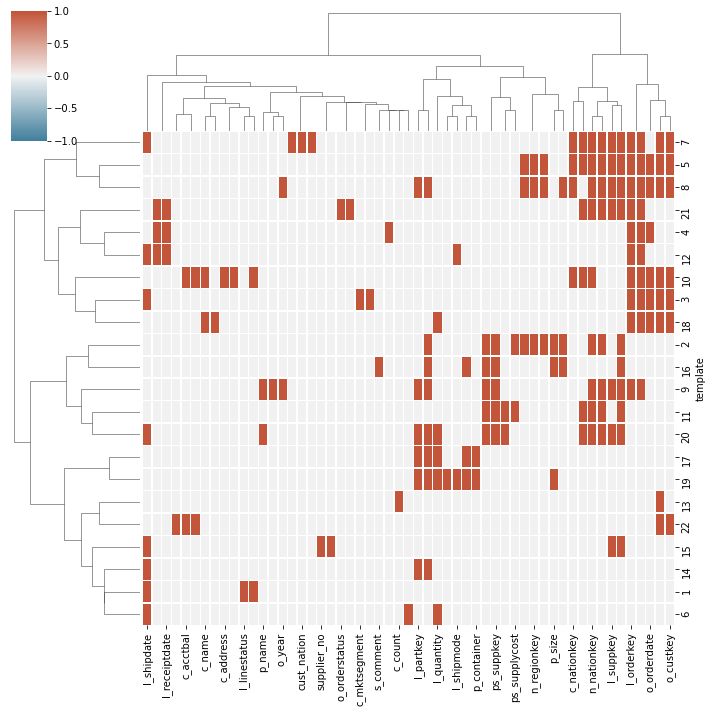

In [5]:
import seaborn as sns
res = sns.clustermap(qcs_ind_df, method='ward', cmap=sns.diverging_palette(230, 20, as_cmap=True), vmax=1, vmin=-1, center=0, square=True, linewidth=.5, cbar_kws={"shrink": .5},)
res

In [6]:
sorted_template_id = [qcs_ind_df.index[row_idx] for row_idx in res.dendrogram_row.reordered_ind]
template_groups = [sorted_template_id[:3], sorted_template_id[3:9], sorted_template_id[9:14], sorted_template_id[14:]]
template_groups

[[7, 5, 8],
 [21, 4, 12, 10, 3, 18],
 [2, 16, 9, 11, 20],
 [17, 19, 13, 22, 15, 14, 1, 6]]

In [ ]:
sorted_cols = [qcs_ind_df.columns[col_idx] for col_idx in res.dendrogram_col.reordered_ind]
sorted_cols

## Generated Workload Analysis

#### Ratio of each template / queried column against all templates/queries in the sliding window

In [73]:
# disable the max row (500 rows) limitation in Altair
alt.data_transformers.disable_max_rows()

brush = alt.selection(type='interval', encodings=['x'], mark=alt.BrushConfig(fill='red', stroke='red', strokeOpacity=0.8))


qcs_background = alt.Chart(df).transform_joinaggregate(total='count(*)').transform_calculate(
    col_pct='1 / datum.total').mark_bar(opacity=0.8).encode(
            alt.X('query_col', type='ordinal', sort = sorted_cols), 
            alt.Y('sum(col_pct):Q')
        ).encode(color=alt.value('#ddd'))
# apply brush filter before aggregation
qcs_highlight = alt.Chart(df).transform_filter(brush).transform_joinaggregate(total='count(*)').transform_calculate(
    col_pct='1 / datum.total').mark_bar(opacity=0.8).encode(
        alt.X('query_col', type='ordinal', sort = sorted_cols), 
        alt.Y('sum(col_pct):Q'))
qcs_histogram = alt.layer(qcs_background, qcs_highlight).properties(
    width=1000,
    height=200
)

template_background = alt.Chart(df).transform_joinaggregate(total='count(*)').transform_calculate(
    col_pct='1 / datum.total').mark_bar(opacity=0.8).encode(
            alt.X('template', type='nominal', sort=sorted_template_id), 
            alt.Y('sum(col_pct):Q', scale=alt.Scale(domain=[0, 0.5]))
        ).encode(color=alt.value('#ddd'))
# apply brush filter before aggregation
template_highlight = alt.Chart(df).transform_filter(brush).transform_joinaggregate(total='count(*)').transform_calculate(
    col_pct='1 / datum.total').mark_bar(opacity=0.8).encode(
        alt.X('template', type='nominal',  sort=sorted_template_id), 
        alt.Y('sum(col_pct):Q', scale=alt.Scale(domain=[0, 0.5])))
template_histogram = alt.layer(template_background, template_highlight).properties(
    width=1000,
    height=200
)

timeframe = alt.Chart(df).mark_area(opacity=0.8).encode(
    alt.X('query_time'), 
    alt.Y('count()'),
    ).add_selection(brush).properties(
    width=1000,
    height=100
)

timetick = alt.Chart(
    df.drop_duplicates(['query_time', 'template'])
).mark_tick().encode(
    x='query_time', 
    color=alt.Color('template:N', sort=sorted_template_id, scale=alt.Scale(scheme="yellowgreenblue"))
).properties(
    width=1000
).add_selection(
    brush
)

vis = alt.vconcat(
    qcs_histogram,
    template_histogram,
    timetick
)
save(vis, 'soft_interactive.json', scale=2.0)
vis

alt.VConcatChart(...)